In [1]:
# !pip install torch torchvision torchaudio

In [2]:
import os
import typing
import torch
import torchvision
import numpy
import pandas
import matplotlib.pyplot as plt


class Sample:

    def __init__(self, image: torch.Tensor, bbox: pandas.DataFrame) -> None:
        self.image = image
        self.bbox = bbox


class Dataset(torch.utils.data.Dataset):

    def __init__(self, folder: str, device: torch.device,
                 label_file_ext="TXT", image_folder="images",
                 target_class=0, bbox_folder="labels") -> None:
        self.__root_folder = folder
        self.__image = {}
        self.__bbox = {}
        self.__device = device
        self.__label_file_ext = label_file_ext
        self.__image_folder = image_folder
        self.__bbox_folder = bbox_folder
        self.__target_class = target_class

        path = f"{self.__root_folder}/{self.__image_folder}/"
        self.__file = [file for file in 
                       os.listdir(path)
                       if os.path.isfile(f"{path}/{file}")]

    def __len__(self) -> int:
        return len(self.__file)

    def get_files(self) -> typing.List[str]:
        return self.__file

    def __getitem__(self, item: int) -> typing.Tuple[torch.Tensor]:
        file = self.__file[item]
        bbox = f"{file[0:file.rfind('.')]}.{self.__label_file_ext}"
        if file not in self.__image:
            self.__image[file] = torchvision.io.read_image(f"{self.__root_folder}/{self.__image_folder}/{file}")

        if bbox not in self.__bbox:
            csv_bbox = read_label_file(f"{self.__root_folder}/{self.__bbox_folder}/{bbox}")
            self.__bbox[bbox] = csv_bbox[csv_bbox['class'] == self.__target_class]

        return Sample(image=self.__image[self.__file[item]],
                      bbox=self.__bbox[bbox])


def read_label_file(filepath) -> pandas.DataFrame:
    return pandas.read_csv(filepath, sep=" ", names=['class', 'cx', 'cy', 'w', 'h'])

In [84]:
def plot_image_with_bbox(image: torch.Tensor, bbox: pandas.DataFrame,
                         colors, labels, scale: bool = False):
    sx = image.size()[2]
    sy = image.size()[1]

    dpi = 100.0
    plt.figure(figsize=(sx/dpi, sy/dpi), dpi=dpi)

    bbox_copy = bbox.copy(deep=True)

    if scale is True:
        bbox_copy['cx'] = bbox_copy['cx']*sx
        bbox_copy['cy'] = bbox_copy['cy']*sy
        bbox_copy['w'] = bbox_copy['w']*sx
        bbox_copy['h'] = bbox_copy['h']*sy

    bboxes = torch.from_numpy(bbox_copy[['cx', 'cy', 'w', 'h']].to_numpy())

    image_bbox = torchvision.ops.box_convert(
        boxes=bboxes,
        in_fmt="cxcywh",
        out_fmt="xyxy")
    image_with_bbox = torchvision.utils.draw_bounding_boxes(
        image=image, labels=labels, boxes=image_bbox, colors=colors
    )
    show_image(image_with_bbox)
    plt.show()

    return image_with_bbox, image_bbox


def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(numpy.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [15]:
data = Dataset(folder="../data/train/exp_4", device=torch.device("cpu"))

In [69]:
import copy


class Model:

    def __init__(self, model, classes, device, preprocess, labels, modify=True) -> None:
        self.__device = device
        self.__orig_model = model
        # self.__weights = weights
        self.__tunned_model = copy.deepcopy(self.__orig_model)
        #if modify is True:
        #    self.__modify(classes=classes)
        self.__tunned_model.to(self.__device)
        self.__preprocess = preprocess
        self.__critery = torchvision.ops.complete_box_iou_loss
        self.__optimizer = torch.optim.SGD(
            self.__tunned_model.parameters(), lr=0.01, momentum=0.9)
        self.__labels = labels

    def __modify(self, classes: int, retrain_all: bool = False):
        model = self.__tunned_model
        if retrain_all is False:
            for param in model.parameters():
                param.requires_grad = False
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        output = torchvision.models.detection.faster_rcnn
        model.roi_heads.box_predictor = output.FastRCNNPredictor(
            in_features, classes)

    def get_model(self):
        return self.__tunned_model

    def train(self,
              dataloader: torch.utils.data.DataLoader,
              epoch_count: int,
              print_info: bool = True
              ):
        self.__model.train()
        for i in range(epoch_count):
            if print_info:
                print(f"Epoch {i+1} / {epoch_count}")
            result_loss = 0
            count = 0
            for item in dataloader:
                count = count + 1
                inputs = item.image.to(self.__device)
                labels = torch.from_numpy(
                    item.bbox[['cx', 'cy', 'w', 'h']].to_numpy())
                self.__optimizer.zero_grad()
                with torch.set_grad_enabled(True):
                    outputs = self.__model(inputs)
                    loss = self.__critery(outputs, labels)
                    loss.backward()
                    self.__optimizer.step()
                    result_loss = result_loss + loss.detach().cpu()
            if count > 0:
                print(f"    Result loss = {result_loss/count}")
            else:
                print("    Error, no image were found")

    def predict(self, inputs: torch.Tensor):
        self.__tunned_model.eval()
        result = self.__tunned_model(inputs)

        return result, [self.__labels[i] for i in result[0]['labels']]

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [70]:
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
core_model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
        weights=weights,
        box_score_thresh=0.7)
model = Model(
    model=core_model,
    preprocess=weights.transforms,
    labels=weights.meta["categories"],
    device=device, classes=2, modify=True)

In [25]:
model.get_model()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [71]:
# %debug
pred_image = torchvision.transforms.functional.convert_image_dtype(
    image=data[1].image.unsqueeze(0),
    dtype=torch.float)
result = model.predict(pred_image)
result

([{'boxes': tensor([[3.8676e-01, 0.0000e+00, 7.0640e+02, 9.0600e+02],
           [2.7787e+02, 5.0228e+02, 7.0020e+02, 8.8699e+02],
           [1.3554e+02, 3.8212e+02, 4.2463e+02, 5.2223e+02],
           [6.0457e+02, 4.0306e+02, 6.9073e+02, 5.5383e+02]],
          grad_fn=<StackBackward0>),
   'labels': tensor([ 1, 17, 32,  1]),
   'scores': tensor([0.9979, 0.9936, 0.9337, 0.7223], grad_fn=<IndexBackward0>)}],
 ['person', 'cat', 'tie', 'person'])

In [91]:
bbox = pandas.DataFrame(
    data=torchvision.ops.box_convert(
        boxes=result[0][0]['boxes'].detach().cpu(),
        in_fmt="xyxy",
        out_fmt="cxcywh").numpy(),
    columns=['cx', 'cy', 'w', 'h'])
bbox

,cx,cy,w,h
0,353.393860,453.000000,706.014160,906.000000
1,489.037567,694.635498,422.332336,384.716522
2,280.083832,452.175171,289.084534,140.113312
3,647.647095,478.444824,86.161560,150.762360


In [90]:
data[0].bbox

,class,cx,cy,w,h
0,0,0.5,0.513194,1.0,0.1875


In [14]:
bbox.loc[0:0]

,cx,cy,w,h
0,272.694489,415.577423,428.382355,127.023926


In [49]:
std = model.get_model().transform.image_std
mean = model.get_model().transform.image_mean
std,mean

([0.229, 0.224, 0.225], [0.485, 0.456, 0.406])

In [29]:
img_res = model.get_model().transform(pred_image)

In [41]:
img_res[0].tensors[0].size()

torch.Size([3, 1024, 800])

<Figure size 800x1024 with 0 Axes>

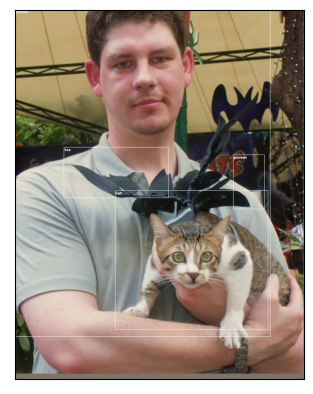

torch.Size([3, 1024, 800])

In [89]:
image = img_res[0].tensors[0]
std = torch.as_tensor(std, dtype=image.dtype, device=image.device).view(-1, 1, 1)
mean = torch.as_tensor(mean, dtype=image.dtype, device=image.device).view(-1, 1, 1)
new_image = copy.deepcopy(image)
new_image = new_image*std + mean
new_image = torchvision.transforms.functional.convert_image_dtype(
    image=new_image,
    dtype=torch.uint8)
img, bb = plot_image_with_bbox(
    image=new_image,
    bbox=bbox,
    colors="#ffffff",
    scale=False,
    labels=result[1]
)
new_image.size()